In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)

import sys
from pyprojroot import here
sys.path.append("..") 

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [3]:
df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

In [4]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


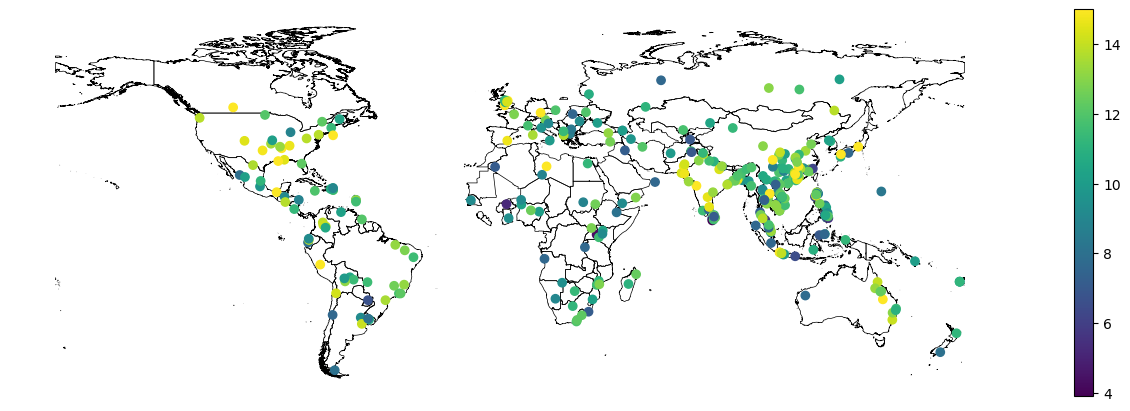

In [5]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
ax.axis('off')
plt.show()

In [6]:
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

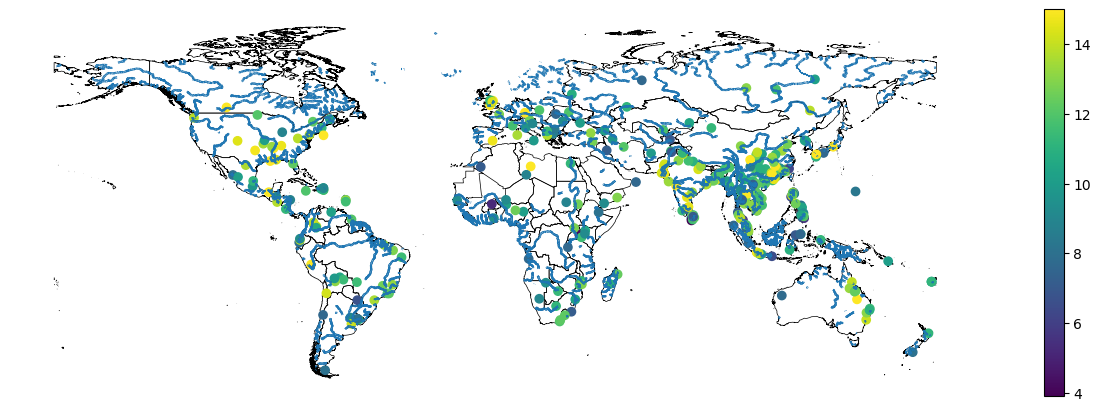

In [7]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
big_rivers.plot(ax=ax)
ax.axis('off')
plt.show()

In [9]:
damage_df.describe()

,Latitude,Longitude,Total_Damage_Hydro,year,closest_river,log_damage_hydro,population_density,gdp_per_cap,Population
count,835.000000,835.000000,3.340000e+02,835,835.000000,334.000000,835.000000,835.000000,8.350000e+02
mean,12.337844,36.774762,8.553866e+05,2010-06-12 13:44:20.119000,150.277988,11.241868,152.813564,7300.769017,2.249954e+08
min,-72.640000,-158.660000,5.000000e+01,2001-01-01 00:00:00,0.066938,3.912023,2.115134,274.131908,1.074500e+05
25%,0.031500,-3.090000,1.210275e+04,2007-01-01 00:00:00,30.404327,9.401081,34.287824,1283.222051,1.820283e+07
50%,14.130000,40.010000,9.900000e+04,2009-01-01 00:00:00,74.258242,11.502824,86.956894,2741.052788,4.713484e+07
75%,26.675000,101.627000,4.835000e+05,2013-01-01 00:00:00,180.680788,13.088805,233.575807,6369.275955,1.654637e+08
max,62.340000,178.080000,4.000000e+07,2020-01-01 00:00:00,6709.026596,17.504390,1257.462995,78893.807736,1.402760e+09
std,20.962088,72.194381,3.259613e+06,NaN,366.100002,2.510174,178.398173,12587.515625,4.109599e+08


In [32]:
damage_df = damage_df.dropna(subset = ["log_damage_hydro"])

In [33]:
import xarray as xr

country_idx, countries = pd.factorize(damage_df.ISO)
year_idx, years = pd.factorize(damage_df.year)

X = damage_df[['River Basin', 'Population', 'gdp_per_cap', 'closest_river']].assign(has_river = lambda x: x['River Basin'].notna().astype(int)).drop(columns=['River Basin'])
X_gp = damage_df[['Latitude', 'Longitude']].copy()
# X_gp['year'] = X_gp['year'].dt.year

coords = {
    'country':countries,
    'year':years,
    'obs_idx':damage_df.index,
    'feature':X.columns,
    'gp_feature': X_gp.columns
}    

xr_idx = xr.Coordinates.from_pandas_multiindex(damage_df.rename(columns={'ISO':'country'}).set_index(['country', 'year']).index, 'obs_idx')

In [34]:
def centered(name, group_dim, mu_loc=0, mu_scale=1, sigma_alpha=2, sigma_beta=1, extra_dims=None, include_loc = True):
    if isinstance(group_dim, str):
        group_dim = (group_dim, )
    if isinstance(extra_dims, str):
        extra_dims = (extra_dims, )

    dims = group_dim if extra_dims is None else (*extra_dims, *group_dim)
    
    if include_loc:
        mu = pm.Normal(f'{name}_mu', mu=mu_loc, sigma=mu_scale, dims=extra_dims)
    else:
        mu = 0
        
    sigma = pm.Gamma(f'{name}_sigma', alpha=sigma_alpha, beta=sigma_beta, dims=extra_dims)
    offset = pm.Normal(f'{name}_offset', dims=dims)
    effect = pm.Deterministic(f'{name}_effect', mu + sigma * offset, dims=dims)
    return effect

In [35]:
pm.find_constrained_prior(
            pm.Gamma,
            lower=3,
            upper=10,
            mass=0.95,
            init_guess={"alpha": 10, "beta": 5},
            mass_below_lower=0,
        ),

({'alpha': 11.622337470267318, 'beta': 1.8612866994444919},)

In [36]:
from sklearn.preprocessing import StandardScaler
from pymc.model.transform.optimization import freeze_dims_and_data

scaler = StandardScaler()
X_scaled = X.copy().astype("float")
X_scaled.loc[:, ['Population', 'gdp_per_cap', 'closest_river']] = scaler.fit_transform(X[['Population', 'gdp_per_cap', 'closest_river']].astype("float").values)

In [37]:
m1, m2 = 50, 50
c = 1.5

In [57]:
with pm.Model(coords=coords) as model:
    country_idx_pt = pm.Data('country_idx', country_idx, dims=['obs_idx'])
    year_idx_pt = pm.Data('year_idx', year_idx, dims=['obs_idx'])
    X_pt = pm.Data('X', X_scaled.values, dims=['obs_idx', 'feature'])
    X_gp_pt = pm.Data('X_gp', X_gp, dims=['obs_idx', 'gp_features'])
    
    country_effect = centered('country', 'country', mu_scale=0.1, sigma_beta=10)
    year_effect = centered('year', 'year', include_loc=False, mu_scale=0.1, sigma_beta=10)
    
    beta = pm.Normal('beta', sigma=0.01, dims=['feature'])
        
    ell = pm.InverseGamma("ell", mu=6.0, sigma=6.5, dims="gp_feature")
    eta = pm.Gamma("eta", alpha=11, beta=2)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell)
    
    gp = pm.gp.HSGP(m=[m1, m2], c=c, cov_func = cov_func)
    phi, sqrt_psd = gp.prior_linearized(X=X_gp_pt)

    basis_coeffs = pm.Normal("basis_coeffs", sigma=0.05, size=gp.n_basis_vectors)
    gp_effect = pm.Deterministic("gp_effect", phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])    
    regression_effect = pm.Deterministic('regression_effect', X_pt @ beta, dims=['obs_idx'])
    
    mu = pm.Deterministic('mu', gp_effect + country_effect[country_idx_pt] + year_effect[year_idx_pt] + regression_effect, dims=['obs_idx'])
    sigma = pm.Exponential('sigma', lam=1)
    
    damage_hat = pm.LogNormal('damage_hat', mu=mu, sigma=sigma, dims='obs_idx',
                             observed=damage_df['Total_Damage_Hydro'].values,
                             shape=country_idx_pt.shape[0])

with freeze_dims_and_data(model):
    prior = pm.sample_prior_predictive(compile_kwargs = {'mode':'JAX'})
prior = prior.assign_coords(xr_idx)

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x1C810303220>), RNG(<Generator(PCG64) at 0x1C810303300>), RNG(<Generator(PCG64) at 0x1C810302F80>), RNG(<Generator(PCG64) at 0x1C810302EA0>), RNG(<Generator(PCG64) at 0x1C810302DC0>), RNG(<Generator(PCG64) at 0x1C810302CE0>), RNG(<Generator(PCG64) at 0x1C810303140>), RNG(<Generator(PCG64) at 0x1C810303060>), RNG(<Generator(PCG64) at 0x1C8103034C0>), RNG(<Generator(PCG64) at 0x1C8103035A0>), RNG(<Generator(PCG64) at 0x1C8103033E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [basis_coeffs, beta, country_mu, country_offset, country_sigma, damage_hat, ell, eta, sigma, year_offset, year_sigma]


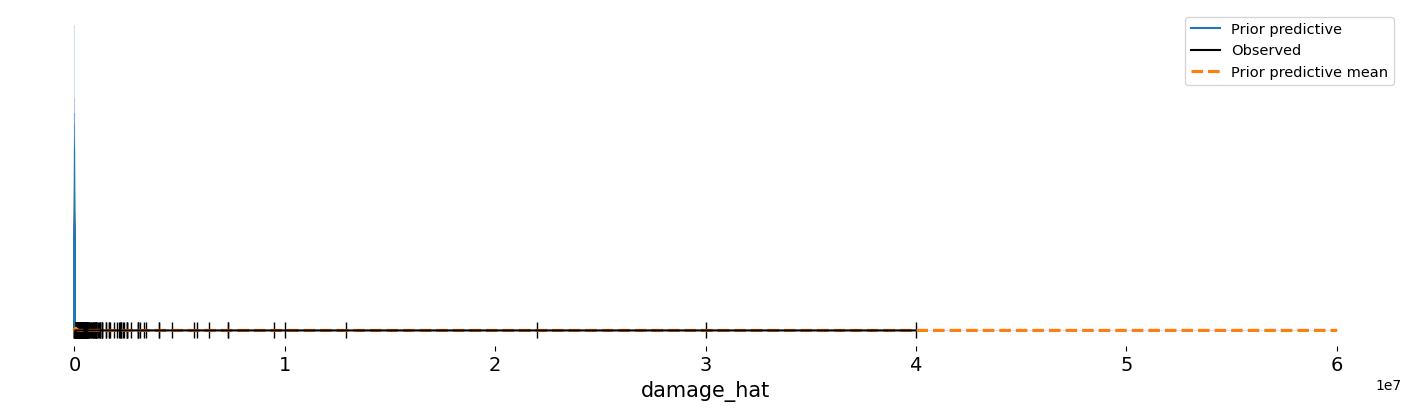

In [58]:
az.plot_ppc(prior, group='prior', observed=True, kind='kde', observed_rug=True);

In [59]:
with freeze_dims_and_data(model):
    idata = pm.sample(nuts_sampler='numpyro', idata_kwargs={'log_likelihood':True}, chains=8, draws=500)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, compile_kwargs={'mode':'JAX'})

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

There were 1537 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x1C81755B5A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [damage_hat]


Output()

<Axes: >

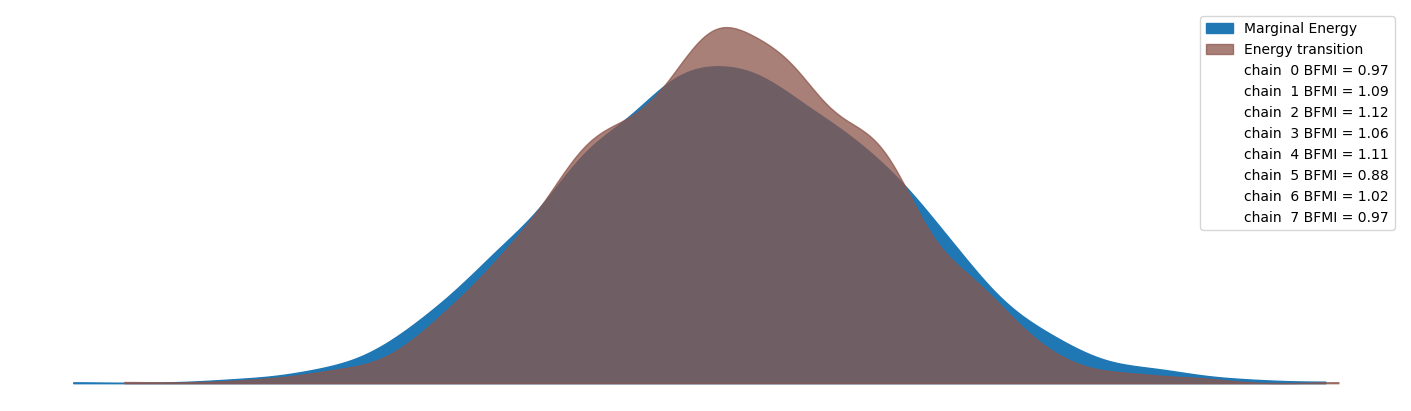

In [60]:
az.plot_energy(idata)

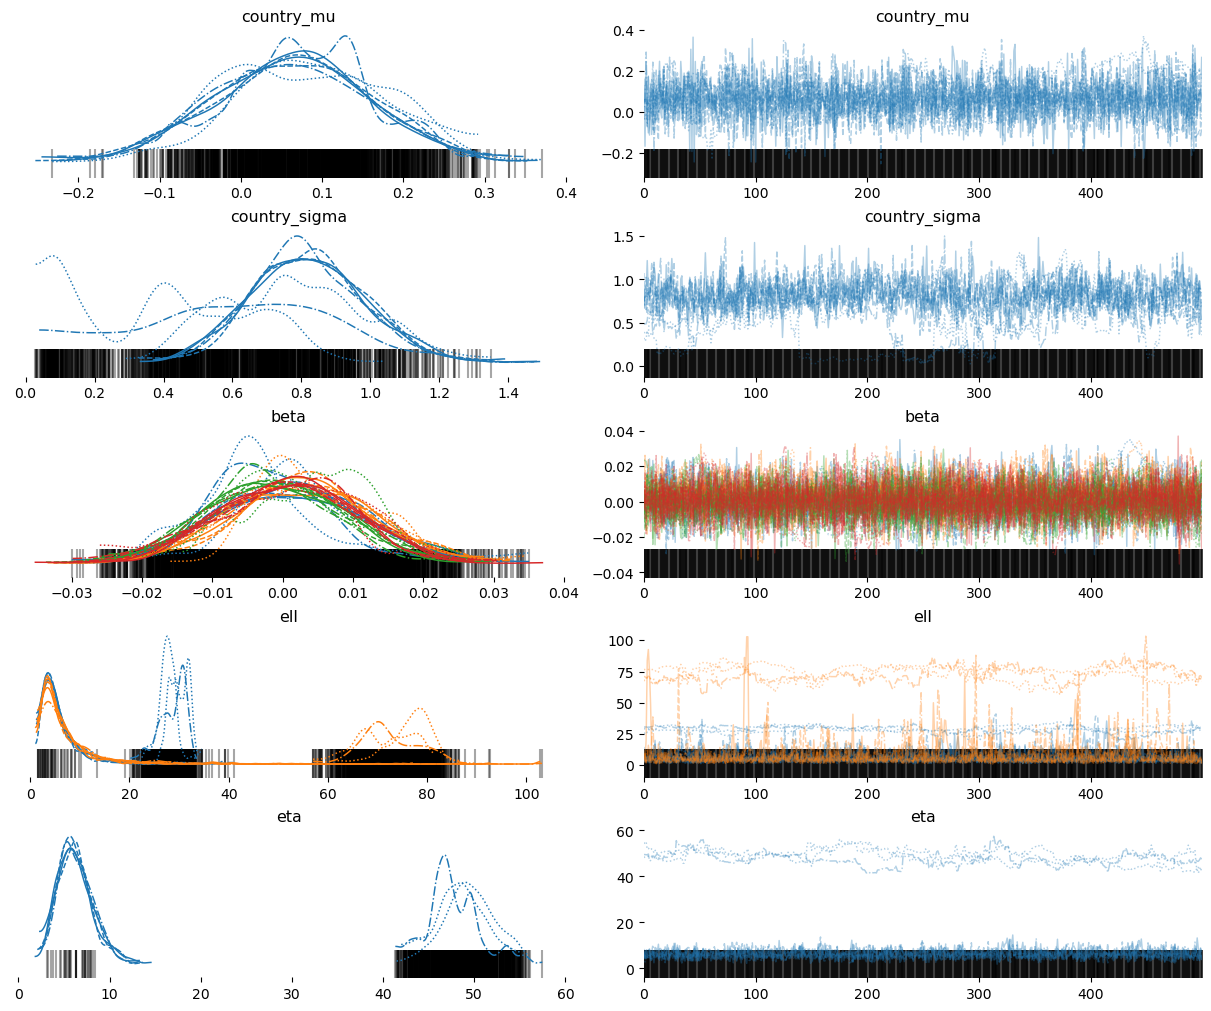

In [61]:
az.plot_trace(idata, var_names=['country_mu', 'country_sigma', 'beta', 'ell', 'eta']);

KeyError: 'var names: "[\'damage_hat_observed\'] are not present" in dataset'

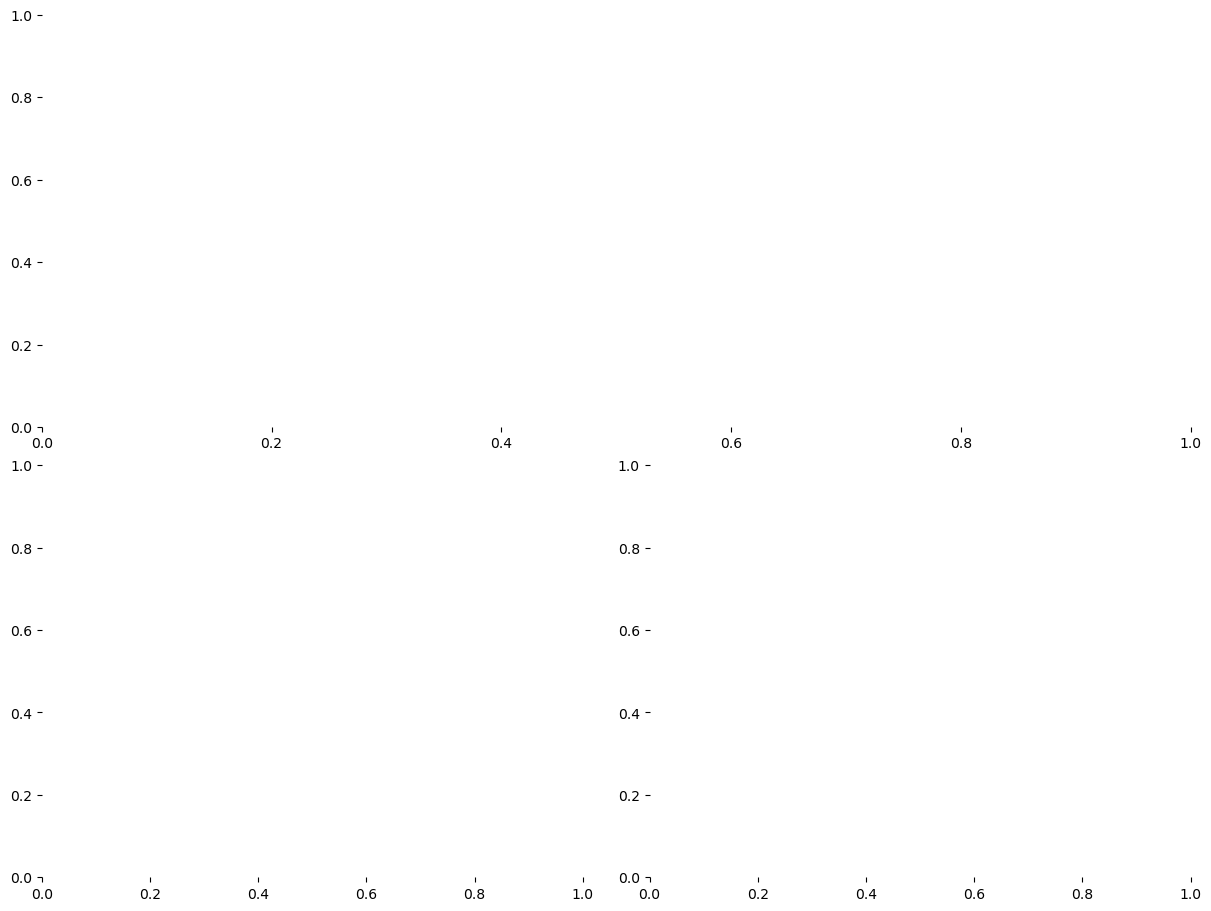

In [43]:
plot_ppc_loopit(idata, 'damage_hat_observed', kind='kde');

In [ ]:
az.plot_forest(idata, var_names=['country_effect'], combined=True);
plt.gcf().tight_layout()
plt.show()

In [108]:
lon_min, lat_min, lon_max, lat_max = laos.bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

In [119]:
laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [120]:
laos_points

,geometry,lon,lat
0,POINT (105.88058 13.99669),105.880578,13.996687
1,POINT (105.95686 13.99669),105.956860,13.996687
2,POINT (106.03314 13.99669),106.033142,13.996687
3,POINT (106.10942 13.99669),106.109425,13.996687
4,POINT (105.8043 14.08355),105.804296,14.083549
...,...,...,...
2975,POINT (101.68506 22.42234),101.685057,22.422344
2976,POINT (101.76134 22.42234),101.761340,22.422344
2977,POINT (101.9139 22.42234),101.913904,22.422344
2978,POINT (101.99019 22.42234),101.990186,22.422344


In [121]:
point_river_distance = get_distance_to_rivers(big_rivers, laos_points)

  0%|          | 0/2980 [00:00<?, ?it/s]

<Axes: >

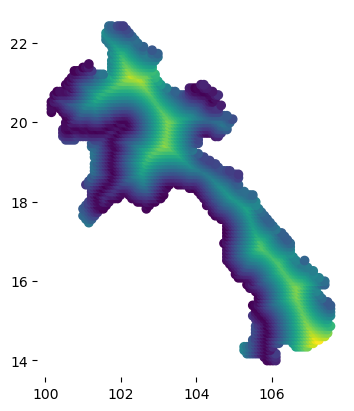

In [164]:
laos_points.join(point_river_distance).plot('closest_river')

In [127]:
scaler.fit_transform(X[].values)

StandardScaler()

In [158]:
with pm.Model(coords=coords) as plotting_model:
    laos_idx = countries.tolist().index('LAO')
    plot_year_idx = [x.year for x in years].index(2020)
    
    lao_row = 1097
    X_gp_laos = laos_points.values[:, 1:].astype(float)
    
#     laos_feature_data = pt.as_tensor_variable(scaler.transform(X.values)[lao_row, :])
    laos_feature_data = X.loc[[lao_row], ['Population', 'gdp_per_cap', 'closest_river']].values
    X_laos = np.ones((laos_points.shape[0], 1)) * laos_feature_data
    X_laos[:, -1] = point_river_distance.values
    X_laos = scaler.transform(X_laos)
    X_laos = np.column_stack((X_laos, np.zeros(X_laos.shape[0])))
    
    country_effect = pm.Flat('country_effect', dims=['country'])
    year_effect = pm.Flat('year_effect', dims=['year'])
    beta = pm.Flat('beta', dims=['feature'])
        
    ell = pm.Flat("ell", dims="gp_feature")
    eta = pm.Flat("eta")
    cov_func = eta**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell)
    
    gp = pm.gp.HSGP(m=[m1, m2], c=1.5, cov_func = cov_func)
    phi, sqrt_psd = gp.prior_linearized(X=X_gp_laos)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)
    gp_effect = phi @ (basis_coeffs * sqrt_psd)  
    
    mu_laos = pm.Deterministic('mu_laos', gp_effect + country_effect[laos_idx] + year_effect[plot_year_idx] + X_laos @ beta)
    sigma = pm.Flat('sigma')
    
    laos_damage = pm.LogNormal('laos_damage', mu=mu_laos, sigma=sigma)

with freeze_dims_and_data(plotting_model):
    idata_plot = pm.sample_posterior_predictive(idata, var_names=['laos_damage'], compile_kwargs={'mode':'JAX'})

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F18B819FA00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [laos_damage]
INFO:pymc.sampling.forward:Sampling: [laos_damage]


Output()

(99.78944501668892, 107.92875479531116, 13.575403876211176, 22.843627243788937)

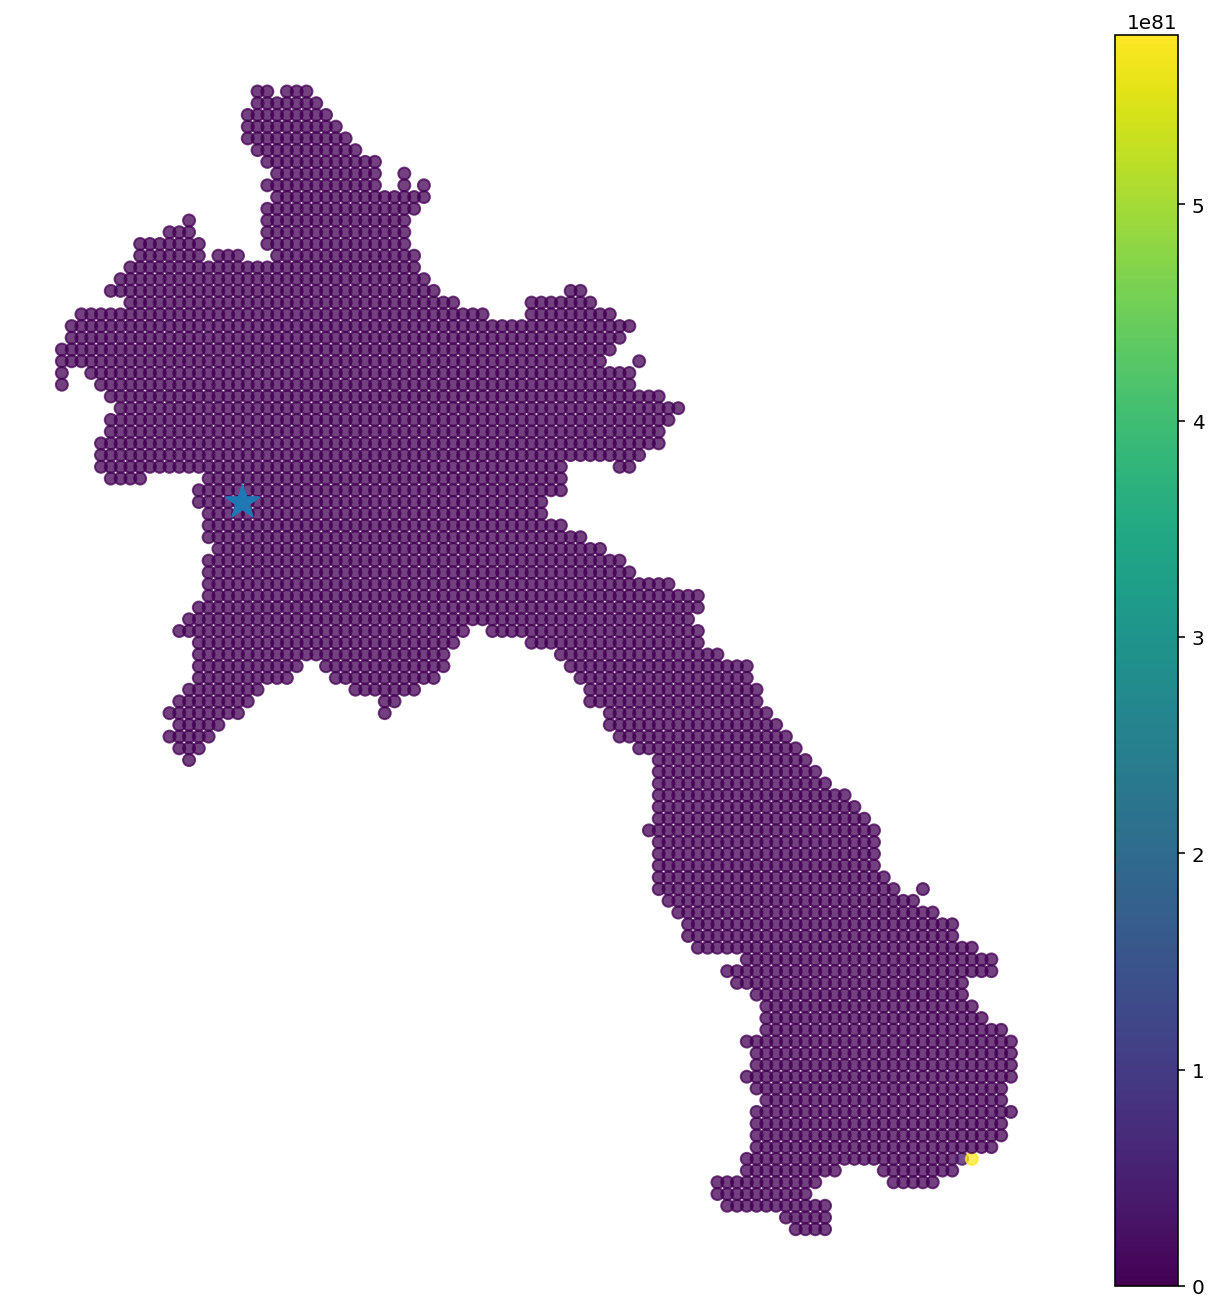

In [159]:
fig, ax = plt.subplots(figsize=(9, 9), dpi=144)
gpd.GeoDataFrame(laos_points.assign(damage_hat = idata_plot.posterior_predictive.laos_damage.mean(dim=['chain', 'draw']).values,
                   geometry = lambda x: gpd.points_from_xy(x=x.lon, y=x.lat))).plot('damage_hat', legend=True, alpha=0.75, ax=ax)
damage_df.query('ISO == "LAO"').plot.scatter(x='Longitude', y='Latitude', marker='*', s=300, ax=ax)
ax.axis('off')

# Non GP model

In [63]:
from laos_gggi.replication_data import create_replication_data

In [64]:
rep_df = create_replication_data()
merged_df = pd.merge(damage_df, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

In [74]:
X_gp.columns

Index(['Latitude', 'Longitude'], dtype='object')

In [72]:
merged_df.columns

Index(['ISO', 'Latitude', 'Longitude', 'River Basin', 'Total_Damage_Hydro',
       'year', 'closest_river', 'log_damage_hydro', 'geometry', 'country_code',
       'population_density', 'gdp_per_cap', 'Population',
       'climatological_disasters', 'hydrological_disasters', 'population',
       'ln_population_density', 'ln_gdp_pc', 'square_ln_gdp_p',
       'dev_from_trend_ocean_temp', 'co2', 'precip_deviation',
       'Total_Damage_Adjusted_hydro', 'Total_Damage_Adjusted_clim',
       'time_period', 'Total_Damage_Adjusted_all'],
      dtype='object')

In [70]:
X_2 = merged_df[['River Basin',  "precip_deviation", "ln_population_density", "ln_gdp_pc", "square_ln_gdp_p", "precip_deviation", "co2", "population",  'has_river']].assign(has_river = lambda x: x['River Basin'].notna().astype(int)).drop(columns=['River Basin'])
X_gp_2 = damage_df[['Latitude', 'Longitude']].copy()
# X_gp['year'] = X_gp['year'].dt.year

coords = {
    'country':merged_df["ISO"].unique(),
    'year':merged_df["year"].unique(),
    'obs_idx':merged_df.index,
    'feature':X_2.columns,
    'gp_feature': X_gp_2.columns
}    

xr_idx = xr.Coordinates.from_pandas_multiindex(damage_df.rename(columns={'ISO':'country'}).set_index(['country', 'year']).index, 'obs_idx')

In [75]:
coords["feature"]

Index(['Population', 'gdp_per_cap', 'closest_river', 'has_river'], dtype='object')